**Makemore v5 with Wavenet**

-   Extension of previous notebook Makemore 3.
-   Kaiming Init for weights
-   Batch Normalization
-   Backprop with torch


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
# read in all the words
words = open("../makemore/names.txt", "r").read().splitlines()
(len(words), words[:5])

(32033, ['emma', 'olivia', 'ava', 'isabella', 'sophia'])

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

In [4]:
# build the dataset

block_size = 3  # How many characters do we take to predict the next one?


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"{X.shape=}\t {Y.shape=}")
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

X.shape=torch.Size([182625, 3])	 Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3])	 Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3])	 Y.shape=torch.Size([22866])


In [5]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # calculate the forward pass

        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                # fmt: off
                self.running_mean = ( 1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = ( 1 - self.momentum) * self.running_var + self.momentum * xvar
                # fmt: on

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings: int, embedding_dim: int):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
# Hyper parameters
torch.manual_seed(42)

n_embed = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP


model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        Flatten(),
        # Hidden layers
        Linear(n_embed * block_size, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        #
        Linear(n_hidden, vocab_size, bias=True),
    ]
)


with torch.no_grad():
    # make last layer less confident
    model.layers[-1].weight *= 0.1  # type: ignore


print(sum(p.nelement() for p in model.parameters()))  # number of parameters in total
for p in model.parameters():
    p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
losses = []
updates = []


for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in model.parameters():
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in model.parameters():
        p.data += -lr * p.grad  # type: ignore

    # track stats
    #
    # 💡 Remember that this loss is for a specific mini batch, and could be less
    # than expected (~1.9). The relevant metric is the output of `split_loss()`.

    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    losses.append(loss.log10().item())

    with torch.no_grad():
        updates.append(
            [
                ((lr * p.grad).std() / p.data.std()).log10().item()
                for p in model.parameters()
            ]  # type: ignore
        )

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2418
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


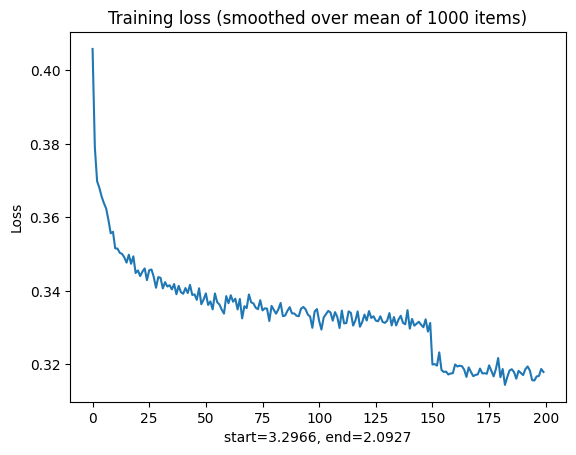

In [8]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))
plt.title("Training loss (smoothed over mean of 1000 items)")
plt.ylabel("Loss")
plt.xlabel(f"start={10 ** losses[0]:.4f}, end={10 ** losses[-1]:.4f}");

In [9]:
# Put layers into evaluation mode
for layer in model.layers:
    layer.training = False

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0583250522613525
val 2.1065292358398438


In [11]:
# sample from the model
torch.manual_seed(2147483647)

# This stateful API is crappy, should ideally avoid this.
for layer in model.layers:
    layer.training = False

for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # break
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

cer.
maleah.
makima.
kayden.
maima.
tainella.
kaman.
a.
samiyah.
javer.
gotti.
moriellah.
jacoreda.
kaley.
maside.
enkavion.
ratls.
malynn.
broahlan.
kashra.
